# Part 2a - Sentence Similarity Clustering
## Transformer only
In this notebook, we cluster the product categories using a transformer approach only.

## Imports

In [25]:
import string
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from collections import Counter
import re

# import helpers module
import helpers
import importlib
importlib.reload(helpers)

SEP = 100 * '-'


## Load dataset

In [26]:
# load dataset
data = helpers.load_pickled_dataset('pickle/data_processed.pkl')

helpers.print_random_product_sheet(data)

Dataset loaded from pickle/data_processed.pkl.
----------------------------------------------------------------------------------------------------
[name] AmazonBasics AAA Performance Alkaline Batteries (36 Count)
----------------------------------------------------------------------------------------------------
[brand] Amazonbasics
----------------------------------------------------------------------------------------------------
[categories] AA,AAA,Health,Electronics,Health & Household,Camcorder Batteries,Camera & Photo,Batteries,Household Batteries,Robot Check,Accessories,Camera Batteries,Health and Beauty,Household Supplies,Batteries & Chargers,Health, Household & Baby Care,Health Personal Care
----------------------------------------------------------------------------------------------------
[reviews.rating] 5.0
----------------------------------------------------------------------------------------------------
[review] Great tablet, just not for my daughter
Tablet is great. I 

## Review Categories

In [27]:
# print unique categories
unique_categories = data['categories'].unique()
print(f'There are {len(unique_categories)} unique categories')

# print(SEP)
# for idx, cat in enumerate(unique_categories):
#     print(f"[{idx}] {cat}")

There are 88 unique categories


Fire Tablets,Tablets,Computers & Tablets,All Table: 9800
AA,AAA,Health,Electronics,Health & Household,Camco: 6415
Stereos,Remote Controls,Amazon Echo,Audio Docks & : 5599
Electronics,iPad & Tablets,All Tablets,Fire Tablet: 3458
Fire Tablets,Tablets,All Tablets,Amazon Tablets,Ge: 2441
Fire Tablets,Tablets,All Tablets,Amazon Tablets,Co: 2439
Fire Tablets,Computers/Tablets & Networking,Electr: 2369
AA,AAA,Electronics Features,Health,Electronics,Hea: 2042
Tablets,Fire Tablets,Computers & Tablets,All Table: 1752
Fire Tablets,Learning Toys,Toys,Tablets,Amazon Tab: 1676
Computers/Tablets & Networking,Tablets & eBook Rea: 1456
Computers,Fire Tablets,Electronics Features,Comput: 1390
Fire Tablets,Computers/Tablets & Networking,Tablet: 987
Fire Tablets,Computers/Tablets & Networking,Tablet: 985
Fire Tablets,Android Tablets,Tablets,All Tablets,A: 699
Computers,Amazon Echo,Virtual Assistant Speakers,A: 624
Amazon Echo,Home Theater & Audio,MP3 MP4 Player Ac: 601
Amazon Echo,Smart Home,Networking,Ho

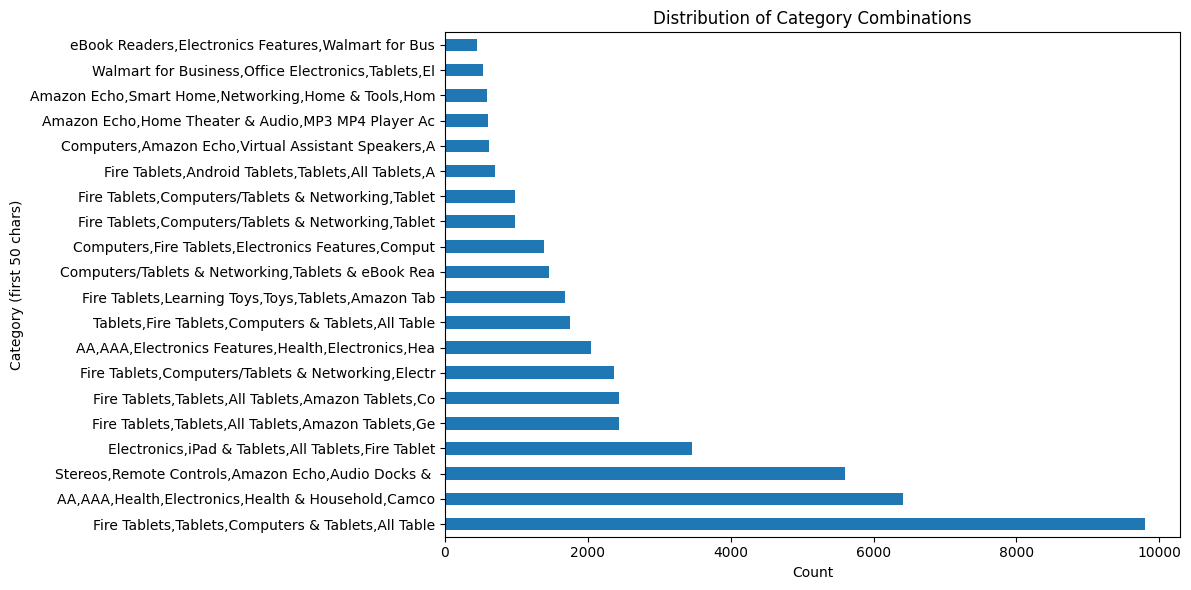

In [28]:
# Check categories balance, how many reviews are there per category
category_counts = data['categories'].value_counts()

for category, count in category_counts.items():
    print(f"{category[:50]}: {count}")

# Plot the distribution with inverted axes
plt.figure(figsize=(12, 6))
cat_filter = 20
bars = category_counts[:cat_filter].plot(kind='barh')
plt.title('Distribution of Category Combinations')
plt.ylabel('Category (first 50 chars)')
plt.xlabel('Count')

# Update the y-axis labels to show only the first 50 characters
bars.set_yticklabels([cat[:50] for cat in category_counts.index[:cat_filter]])

plt.tight_layout()
plt.show()


The amount of reviews per category is highly unbalanced. We need to group them as best as possible to balanced sub categories

## Model choice

We can opt for a Feature Extraction or Sentence Similarity model. 

Given the complex and hierarchical nature of our categories, Feature Extraction is recommended for generating embeddings that capture the structure and relationships within each category string. Unlike Sentence Similarity, which focuses on general semantic content, Feature Extraction is better suited for the nuanced clustering of multi-level categories. 

However, we can start with a Transformer-only approach and compare it to a Transformer + ML model in a second notebook (2b).

Let's use [sentence-transformers/all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) as a all-in-one solution to take care of embeddings and clustering. The sentence-transformers library provides a method for hierarchical agglomerative clustering (HAC), which is designed for this kind of task and works well for text.

## Create Corpus
We can try two approches: Clustering the names of the categories, or clustering the product names concatenated by categories.

**RESULTS:**  
I tried both solutions and got a better clustering with less misclassifications using categories as input, rather than product names.

In [ ]:
# create corpus from categories
corpus_categories = data['categories'].unique().tolist()
print(len(corpus_categories), 'unique categories')
print(SEP)
print('Example:', corpus_categories[0])

88 unique categories
----------------------------------------------------------------------------------------------------
Example: Featured Brands,E-Readers & Accessories,EBook Readers,Tablets,Amazon Book Reader,Electronics,Computers & Tablets,Amazon Ereaders,Kindle E-readers,Amazon Devices,Tablets & E-Readers,E-Readers


In [ ]:
# Create corpus from product names concatenated by categories

# Define a translation table to remove punctuation and quotes
unwanted_chars = str.maketrans('', '', string.punctuation + "'\"")

# Function to clean and de-duplicate product names
def clean_product_names(names):
    cleaned_names = set()
    for name in names:
        # Remove unwanted characters, newline, and extra whitespace
        cleaned_name = name.translate(unwanted_chars).replace("\r", "").replace("\n", "").strip()
        # Remove recurring words that carry no meaning
        black_list = ['Amazon', 'AmazonBasics']
        for word in black_list:
            if word in cleaned_name:
                cleaned_name = cleaned_name.replace(word, "").strip()
        # Remove multiple spaces
        cleaned_name = ' '.join(cleaned_name.split())
        # Add cleaned name to the set to ensure uniqueness
        cleaned_names.add(cleaned_name)
    return list(cleaned_names)

# Group by 'categories', apply cleaning, and convert to dictionary
category_product_dict = data.groupby('categories')['name'].apply(clean_product_names).to_dict()

# create corpus from product names concatenated by category
corpus_names = [','.join(products) for products in category_product_dict.values()]
print('Product names concatenated in', len(corpus_names), 'unique categories')
print(SEP)
print('Example:', corpus_names[0])

Product names concatenated in 88 unique categories
----------------------------------------------------------------------------------------------------
Example: Basics AA Performance Alkaline Batteries 48 Count Packaging May Vary


## Define corpus to use

In [ ]:
# define which corpus to use in the next cells
corpus = corpus_categories  # better clustering results
# corpus = corpus_names  # poor clustering

## Load Model and cluster corpus

In [ ]:
# initialise model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')

# Generate embeddings on both corpus
corpus_embeddings = model.encode(corpus, convert_to_tensor=True)

# Use SentenceTransformer's built-in clustering with hierarchical clustering
cluster_assignment = util.community_detection(corpus_embeddings, min_community_size=3, threshold=0.7)
print(cluster_assignment)
print()

# Create a list of cluster indices for each category
cluster_assignment_flat = np.zeros(len(corpus), dtype=int)
for cluster_idx, indices in enumerate(cluster_assignment):
    for idx in indices:
        cluster_assignment_flat[idx] = cluster_idx
print(cluster_assignment_flat)
print()

# Organize clustered categories
corpus_clustered = [[] for _ in range(len(cluster_assignment))]
for category_id, cluster_id in enumerate(cluster_assignment_flat):
    corpus_clustered[cluster_id].append(corpus[category_id])

# prit clustering results
for i, cluster in enumerate(cluster_assignment):
    print(f"Cluster {i}: {len(cluster)} categories")

[[0, 1, 7, 8, 17, 20, 25, 26, 28, 29, 35, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72], [2, 10, 12, 13, 15, 16, 23, 73, 75, 80, 81, 82, 83, 84, 85, 87], [5, 19, 21, 30, 36, 40, 78], [4, 33, 34, 79], [6, 27, 37, 66], [18, 51, 53]]

[0 0 1 0 3 2 4 0 0 0 1 0 1 1 0 1 1 0 5 2 0 2 0 1 0 0 0 4 0 0 2 0 0 3 3 0 2
 4 0 0 2 0 0 0 0 0 0 0 0 0 0 5 0 5 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 1
 0 1 0 0 2 3 1 1 1 1 1 1 0 1]

Cluster 0: 41 categories
Cluster 1: 16 categories
Cluster 2: 7 categories
Cluster 3: 4 categories
Cluster 4: 4 categories
Cluster 5: 3 categories


In [35]:
# Dictionary to store the most common words for each cluster
cluster_words = {}

# ignore some recurrent words
ignored_words = ['Amazon', 'from', 'To']

# Process each cluster
for i, cluster in enumerate(corpus_clustered):

    # Clean and prepare the cluster text
    clean_cluster = re.sub(r'[^A-Za-z0-9\s]', '', " ".join(cluster))
    all_words = [word.strip() for word in clean_cluster.split()]

    # Count frequency of each word and get top 10
    word_counts = Counter(all_words)
    for word in ignored_words:
        if word in word_counts:
            del word_counts[word]
    most_common_words = word_counts.most_common(10)

    # Store the results in the dictionary
    cluster_words[f"Cluster {i}"] = most_common_words

    # Print results for inspection
    print(f"CLUSTER {i}:")
    for word, count in most_common_words:
        print(f"{word} ({count})")
    print(SEP)

CLUSTER 0:
Fire (22)
TabletsAmazon (16)
eBook (15)
Tablets (14)
TabletsAll (12)
TabletsComputers (12)
Readers (11)
TabletsComputersTablets (10)
Adapters (9)
Device (9)
----------------------------------------------------------------------------------------------------
CLUSTER 1:
Home (28)
Device (15)
Smart (14)
Audio (14)
Speakers (14)
Assistant (11)
Hubs (9)
Wireless (8)
Player (7)
Hub (7)
----------------------------------------------------------------------------------------------------
CLUSTER 2:
Device (4)
Drive (4)
Adapters (3)
AccessoriesComputer (3)
Accessories (3)
Computers (2)
Reader (2)
Bags (2)
TabletsElectronics (2)
Media (2)
----------------------------------------------------------------------------------------------------
CLUSTER 3:
more (4)
Kindle (4)
Voyage (4)
Home (4)
AccessoriesKindle (3)
Video (3)
Device (2)
5th (2)
Generation (2)
eBook (2)
----------------------------------------------------------------------------------------------------
CLUSTER 4:
Accessories (

## Plot clustering results

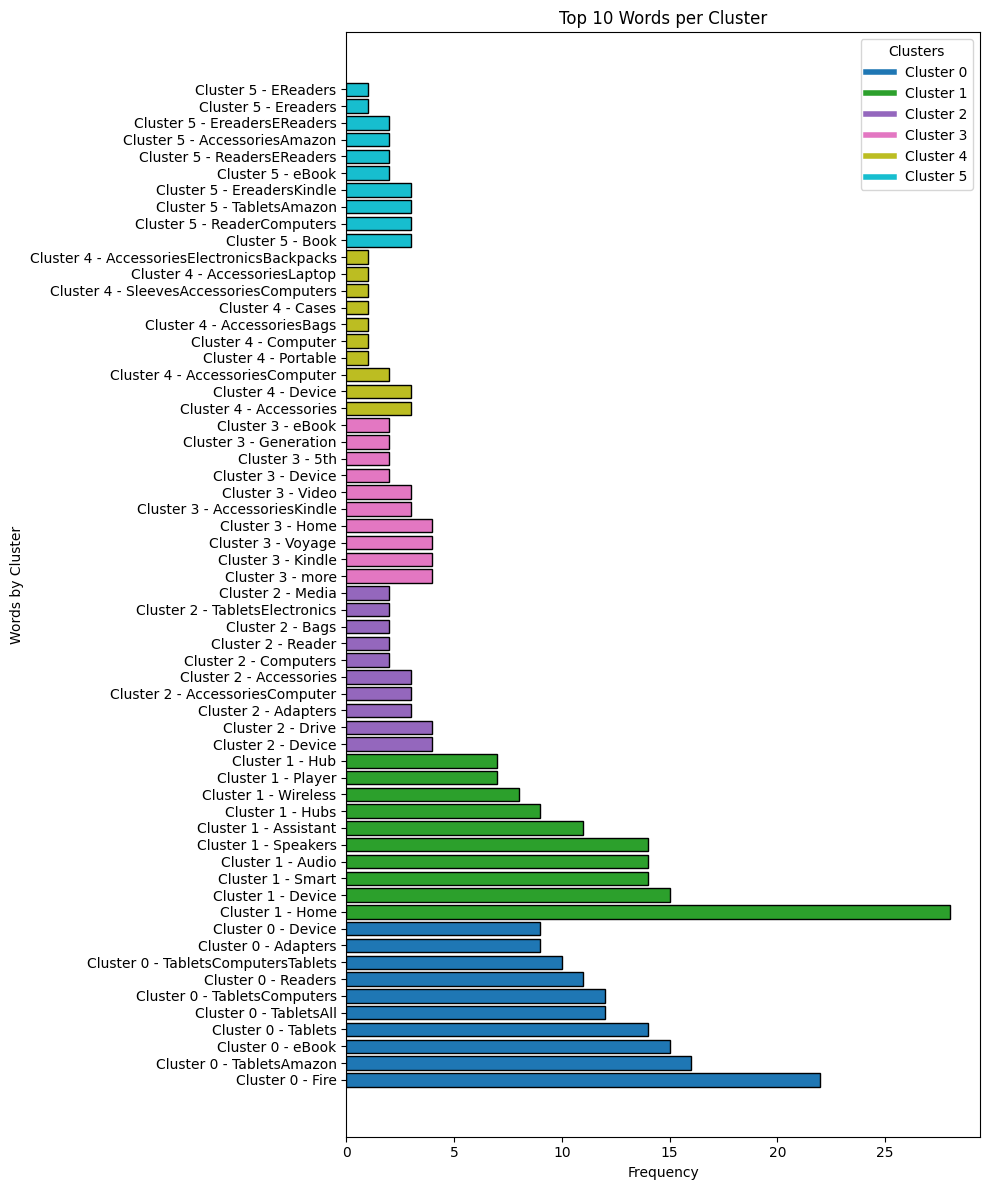

In [36]:
# Generate distinct colors for each cluster
colors = plt.cm.tab10(np.linspace(0, 1, len(cluster_words)))

# Prepare data for plotting
words = []
counts = []
color_map = []
cluster_labels = []

for idx, (cluster, word_count_list) in enumerate(cluster_words.items()):
    for word, count in word_count_list:
        words.append(f"{cluster} - {word}")
        counts.append(count)
        color_map.append(colors[idx])
        cluster_labels.append(cluster)

# Plotting
plt.figure(figsize=(10, 12))
plt.barh(words, counts, color=color_map, edgecolor="black")

# Legend
legend_labels = [f"Cluster {i}" for i in range(len(cluster_words))]
unique_colors = [colors[i] for i in range(len(cluster_words))]
custom_legend = [plt.Line2D([0], [0], color=unique_colors[i], lw=4) for i in range(len(unique_colors))]
plt.legend(custom_legend, legend_labels, title="Clusters", loc="upper right")

# Labels and title
plt.ylabel("Words by Cluster")
plt.xlabel("Frequency")
plt.title("Top 10 Words per Cluster")

plt.tight_layout()
plt.show()

In [ ]:
# Calculate silhouette score

# Prepare cluster labels for each data point in the original order
cluster_labels = [-1] * len(corpus_embeddings)  # Initialize all labels to -1 (unassigned)
for cluster_id, cluster in enumerate(cluster_assignment):
    for idx in cluster:
        cluster_labels[idx] = cluster_id

# Ensure all points have been assigned to a cluster (Silhouette Score requires all points to be labeled)
counter = 0
if -1 in cluster_labels:
    counter += 1
if counter > 0:
    print(f"Warning: {counter} points were not assigned to any cluster. Silhouette Score may not be accurate.")

# Compute Silhouette Score using the embeddings and generated cluster labels
# Convert embeddings to CPU tensor if required by silhouette_score
if corpus_embeddings.is_cuda:
    corpus_embeddings = corpus_embeddings.cpu()

silhouette_avg = silhouette_score(corpus_embeddings, cluster_labels)
print(f'Silhouette Score: {silhouette_avg}')


Silhouette Score: 0.08917417377233505


## Visualise clustering results
Let's use t-SNE to visualise our clusters once we reduce the results to 2 dimensions

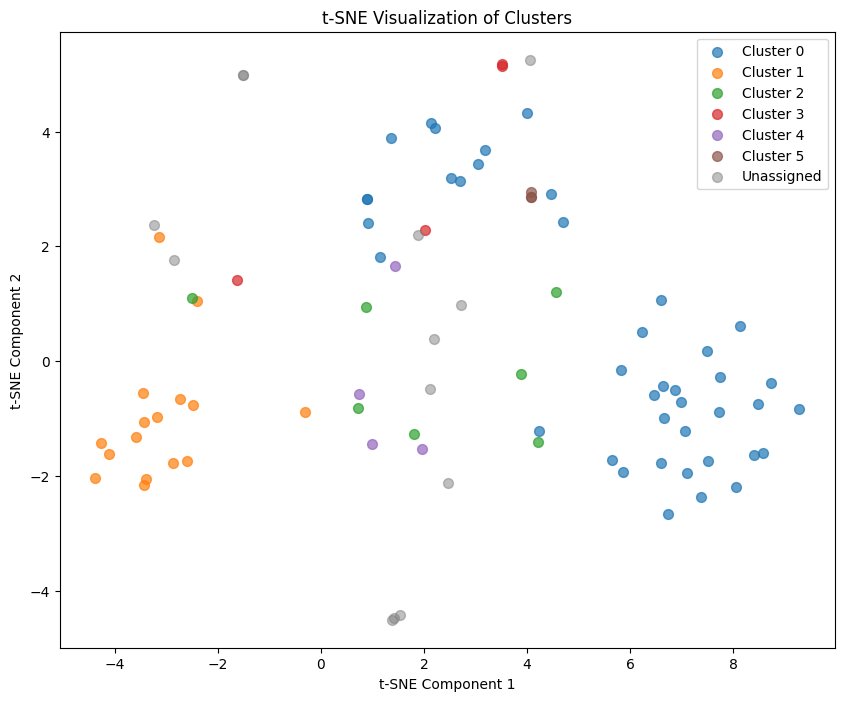

In [37]:
# Step 1: Run t-SNE on the embeddings
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(corpus_embeddings.cpu())  # Convert to CPU if on GPU

# Step 2: Prepare a color map for clusters
num_clusters = max(cluster_labels) + 1  # Get the number of clusters
plt.figure(figsize=(10, 8))

# Step 3: Plot each point with its cluster label
for cluster_id in range(num_clusters):
    indices = [i for i, label in enumerate(cluster_labels) if label == cluster_id]
    plt.scatter(
        embeddings_2d[indices, 0], embeddings_2d[indices, 1],
        label=f'Cluster {cluster_id}', alpha=0.7, s=50
    )

# Mark unassigned points, if any (-1)
if -1 in cluster_labels:
    unassigned_indices = [i for i, label in enumerate(cluster_labels) if label == -1]
    plt.scatter(
        embeddings_2d[unassigned_indices, 0], embeddings_2d[unassigned_indices, 1],
        color="gray", label="Unassigned", alpha=0.5, s=50
    )

# Step 4: Add plot details
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()


The t-SNE visualization shows very poor clustering results, with some clusters well defined and others mixed up.